In [9]:
import pandas as pd
import numpy as np

import keras
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer


## Load data

In [3]:
text_data = pd.read_csv('./texts.csv')

text_data.head()

,Unnamed: 0,text,subject_id,hadm_id,mortality
0,0,sinus bradycardia av conduction delay qt inter...,67393,146953.0,0
1,1,baseline artifact sinus rhythm right bundle br...,9142,198248.0,1
2,2,atrial fibrillation possible flutter ventricul...,73608,162231.0,0
3,3,mobitz ii second degree av block nonconducted ...,29016,153345.0,0
4,4,sinus rhythm normal tracing previous tracing a...,12834,107726.0,0


In [28]:
X, y = text_data['text'], text_data['mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

In [29]:
X_train.shape

(26592,)

In [30]:
# Tokenize the train text
train_text = X_train.to_numpy()

tokenizer = Tokenizer(
    num_words=3000, 
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True,
    split=" ",
    char_level=False,
    oov_token='<unk>',
    document_count=0
)

tokenizer.fit_on_texts(train_text)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [49]:
train_seqs = tokenizer.texts_to_sequences(train_text)
train_seqs = keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=300, padding='post')

train_labels = y_train.to_numpy().flatten()

valid_text = X_test.to_numpy()
valid_seqs = tokenizer.texts_to_sequences(valid_text)
valid_seqs = keras.preprocessing.sequence.pad_sequences(valid_seqs, maxlen=300, padding='post')

valid_labels = y_test.to_numpy().flatten()

In [50]:
train_seqs

array([[   1,  687,    1, ...,  102,   90, 1270],
       [  37,  404,   28, ...,  275,  732,  580],
       [  29,   26,  131, ...,  237,   48,  175],
       ...,
       [  22,  660,    5, ..., 1072, 1286,    1],
       [ 393,   33,  558, ...,   33,  866,    7],
       [ 108,   33,  341, ...,  427, 1341,  510]], dtype=int32)

In [51]:
train_seqs.shape

# (30455, 606752) without preprocessing/limiting and truncating

(26592, 300)

## LSTM model

In [38]:
# # Create the text encoder
# VOCAB_SIZE = 1000
# encoder = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
# encoder.adapt(train_text)

# vocab = np.array(encoder.get_vocabulary())
# vocab[:20]

array(['', '[UNK]', 'left', 'reason', 'clip', 'right', 'chest', 'pt',
       'name', 'hospital', 'pm', 'radiology', 'examination', 'report',
       'number', 'final', 'ct', 'old', 'medical', 'tracing'], dtype='<U17')

In [53]:
def Classifier(input_size):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=3000, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(64, activation='tanh', return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LSTM(16, activation='tanh', return_sequences=False)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    classifier = keras.Model(inputs, outputs)
    
    return classifier

In [55]:
classifier = Classifier(input_size=1000)

optimizer = keras.optimizers.Adam(lr=0.0001)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 64)          256       
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                5184      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17  

In [57]:
classifier = Classifier(input_size=300)

optimizer = keras.optimizers.Adam(lr=0.0001)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

classifier.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 300, 64)           192000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 300, 64)           33024     
_________________________________________________________________
batch_normalization_6 (Batch (None, 300, 64)           256       
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                5184      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17  

In [58]:
# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True) # patient = 5 or 10 doesn't guarantee find an optimal

# Train the model
# reset_seeds()
classifier_history = classifier.fit(train_seqs, 
          y_train, 
          epochs=50,
          batch_size=32,
          shuffle=True, 
          verbose=True, 
          validation_data=(valid_seqs, y_test),
          callbacks=[early_stopping_accuracy])

Epoch 1/50
831/831 [==============================] - 87s 101ms/step - loss: 0.6980 - accuracy: 0.5915 - val_loss: 0.5277 - val_accuracy: 0.8343
Epoch 2/50
831/831 [==============================] - 82s 99ms/step - loss: 0.5056 - accuracy: 0.8322 - val_loss: 0.4247 - val_accuracy: 0.8555
Epoch 3/50
831/831 [==============================] - 82s 99ms/step - loss: 0.3906 - accuracy: 0.8714 - val_loss: 0.3824 - val_accuracy: 0.8637
Epoch 4/50
831/831 [==============================] - 84s 101ms/step - loss: 0.3147 - accuracy: 0.8866 - val_loss: 0.4368 - val_accuracy: 0.8649
Epoch 5/50
831/831 [==============================] - 83s 100ms/step - loss: 0.2534 - accuracy: 0.9075 - val_loss: 0.3467 - val_accuracy: 0.8693
Epoch 6/50
831/831 [==============================] - 83s 99ms/step - loss: 0.2045 - accuracy: 0.9307 - val_loss: 0.4325 - val_accuracy: 0.8218
Epoch 7/50
831/831 [==============================] - 82s 99ms/step - loss: 0.1738 - accuracy: 0.9408 - val_loss: 0.5453 - val_accura

NameError: name 'plot_graphs' is not defined

In [61]:
import matplotlib.pyplot as plt

# Method: For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

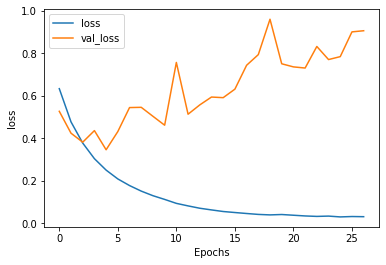

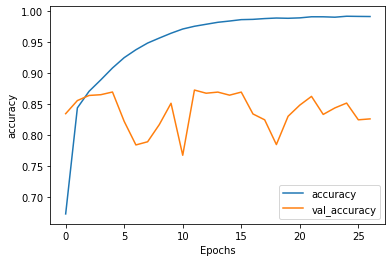

In [62]:
plot_graphs(classifier_history, "loss")
plot_graphs(classifier_history, "accuracy")

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = classifier.predict(valid_seqs)
y_pred_classes = np.array([1 if pred > 0.5 else 0 for pred in y_pred])

# classification report
acc = accuracy_score(y_true=y_test, y_pred=y_pred_classes)

confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_test, y_pred=y_pred_classes, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
confusion_matrix_df

,Pred:pos,Pred:neg
True:pos,214,707
True:neg,141,5587


In [68]:
acc

0.8724620243645661

In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5728
           1       0.60      0.23      0.34       921

    accuracy                           0.87      6649
   macro avg       0.75      0.60      0.63      6649
weighted avg       0.85      0.87      0.85      6649

